In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. 하이퍼파라미터 설정 (Hyperparameters) ---
INPUT_DIM = 7  # zA(3) + zB(3) + alpha(1)
OUTPUT_DIM = 3 # z_interp(3)
HIDDEN_DIM = 128
LEARNING_RATE = 1e-4
BATCH_SIZE = 256
NUM_EPOCHS = 50
LAMBDA = 0.1 # 매력 항의 가중치 (Weight for the attraction term)

# --- 2. 보간 네트워크 정의 (Interpolation Network Definition) ---
class InterpolationNet(nn.Module):
    def __init__(self):
        super(InterpolationNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, OUTPUT_DIM)
        )

    def forward(self, x):
        return self.network(x)

# --- 3. 구 표면 데이터셋 정의 (Sphere Dataset Definition) ---
class SphereDataset(Dataset):
    def __init__(self, num_samples=100000):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # 표준 정규분포에서 무작위 벡터 2개를 생성
        z_a = torch.randn(3)
        z_b = torch.randn(3)
        
        # 단위 구 표면으로 정규화하여 z_A와 z_B를 얻음
        z_a = z_a / torch.linalg.norm(z_a)
        z_b = z_b / torch.linalg.norm(z_b)
        
        # 보간 계수 alpha를 무작위로 샘플링
        alpha = torch.rand(1)
        
        return z_a, z_b, alpha

# --- 4. 손실 함수 정의 (Loss Function Definition) ---
def composite_loss(z_interp, z_linear, lambda_val):
    # 재투영 오차 (Re-projection Error)
    # z_interp를 단위 구로 투영
    z_proj = z_interp / (torch.linalg.norm(z_interp, dim=1, keepdim=True) + 1e-8)
    loss_reproj = torch.mean(torch.sum((z_interp - z_proj)**2, dim=1))

    # 매력 항 (Attraction Term)
    loss_attraction = torch.mean(torch.sum((z_interp - z_linear)**2, dim=1))
    
    # 최종 손실
    total_loss = loss_reproj + lambda_val * loss_attraction
    return total_loss, loss_reproj, loss_attraction

# --- 5. 시각화 함수 정의 (Visualization Function Definition) ---
def visualize_results(model):
    print("\nVisualizing trained model performance...")
    model.eval() # 평가 모드로 설정 (Set model to evaluation mode)
    
    # 테스트용 데이터 생성
    z_a = torch.randn(3)
    z_a = z_a / torch.linalg.norm(z_a)
    z_b = torch.randn(3)
    z_b = z_b / torch.linalg.norm(z_b)

    alphas = torch.linspace(0, 1, 100).view(-1, 1)
    
    # Slerp (정답 경로) 계산
    omega = torch.acos(torch.dot(z_a, z_b).clamp(-1, 1))
    sin_omega = torch.sin(omega)
    slerp_path = (torch.sin((1 - alphas) * omega) / sin_omega) * z_a.unsqueeze(0) + \
                 (torch.sin(alphas * omega) / sin_omega) * z_b.unsqueeze(0)

    # Lerp (선형 경로) 계산
    lerp_path = (1 - alphas) * z_a.unsqueeze(0) + alphas * z_b.unsqueeze(0)
    
    # 네트워크가 학습한 경로 계산
    learned_path = []
    with torch.no_grad():
        for alpha in alphas:
            net_input = torch.cat([z_a, z_b, alpha], dim=0).unsqueeze(0)
            output = model(net_input)
            learned_path.append(output.squeeze(0))
    learned_path = torch.stack(learned_path)

    # 3D 플롯 생성
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 구 표면 그리기
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.3)

    # 경로 그리기
    ax.plot(slerp_path[:, 0], slerp_path[:, 1], slerp_path[:, 2], label='Slerp (Ground Truth)', color='g', linewidth=4)
    ax.plot(lerp_path[:, 0], lerp_path[:, 1], lerp_path[:, 2], label='Lerp (Linear Path)', color='r', linestyle='--')
    ax.plot(learned_path[:, 0], learned_path[:, 1], learned_path[:, 2], label='Learned Path', color='b', linewidth=4, linestyle=':')

    # 시작점과 끝점 그리기
    ax.scatter(z_a[0], z_a[1], z_a[2], s=100, c='orange', marker='o', label='Start (zA)')
    ax.scatter(z_b[0], z_b[1], z_b[2], s=100, c='purple', marker='X', label='End (zB)')

    ax.set_title("Interpolation Path on a 3D Sphere") # 타이틀: 3D 구 위의 보간 경로
    ax.legend()
    plt.show()

# --- 6. 메인 학습 로직 (Main Training Logic) ---
if __name__ == "__main__":
    # 모델, 데이터셋, 데이터로더 초기화
    model = InterpolationNet()
    dataset = SphereDataset()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"Starting training for {NUM_EPOCHS} epochs...")
    for epoch in range(NUM_EPOCHS):
        total_loss_epoch = 0
        for z_a_batch, z_b_batch, alpha_batch in dataloader:
            
            # 네트워크 입력 준비
            net_input = torch.cat([z_a_batch, z_b_batch, alpha_batch], dim=1)

            # 순전파
            z_interp = model(net_input)
            
            # 손실 계산을 위한 선형 보간값(기준점) 계산
            z_linear = (1 - alpha_batch) * z_a_batch + alpha_batch * z_b_batch

            # 손실 계산 및 역전파
            optimizer.zero_grad()
            loss, _, _ = composite_loss(z_interp, z_linear, LAMBDA)
            loss.backward()
            optimizer.step()
            
            total_loss_epoch += loss.item()
        
        avg_loss = total_loss_epoch / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Average Loss: {avg_loss:.6f}")

    print("Training finished.")
    
    # 학습 완료 후 결과 시각화
    visualize_results(model)

Using device: cuda:1
Starting training for 50 epochs...
Epoch [10/50], Average Loss: 0.009878
Epoch [20/50], Average Loss: 0.007915
Epoch [30/50], Average Loss: 0.007580
Epoch [40/50], Average Loss: 0.007312
Epoch [50/50], Average Loss: 0.007321
Training finished.

Visualizing trained model performance...


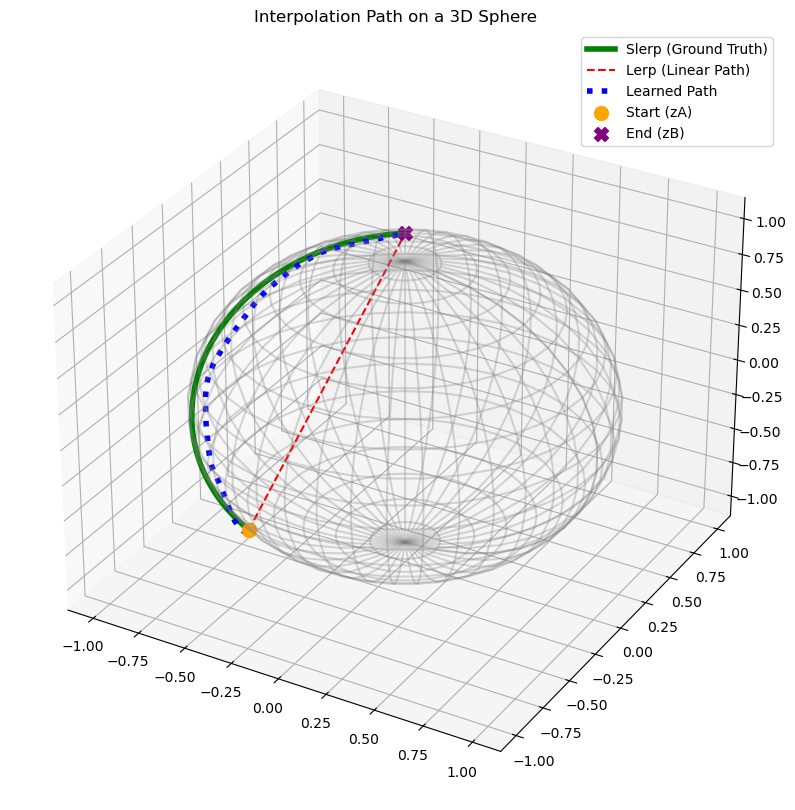

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. 하이퍼파라미터 설정 (Hyperparameters) ---
INPUT_DIM = 7
OUTPUT_DIM = 3
HIDDEN_DIM = 128
LEARNING_RATE = 1e-4
BATCH_SIZE = 256
NUM_EPOCHS = 50
LAMBDA = 0.1

# --- 2. 보간 네트워크 정의 (Interpolation Network Definition) ---
class InterpolationNet(nn.Module):
    def __init__(self):
        super(InterpolationNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, OUTPUT_DIM)
        )

    def forward(self, x):
        return self.network(x)

# --- 3. 구 표면 데이터셋 정의 (Sphere Dataset Definition) ---
class SphereDataset(Dataset):
    def __init__(self, num_samples=100000):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        z_a = torch.randn(3)
        z_b = torch.randn(3)
        z_a = z_a / torch.linalg.norm(z_a)
        z_b = z_b / torch.linalg.norm(z_b)
        alpha = torch.rand(1)
        return z_a, z_b, alpha

# --- 4. 손실 함수 정의 (Loss Function Definition) ---
def composite_loss(z_interp, z_linear, lambda_val):
    z_proj = z_interp / (torch.linalg.norm(z_interp, dim=1, keepdim=True) + 1e-8)
    loss_reproj = torch.mean(torch.sum((z_interp - z_proj)**2, dim=1))
    loss_attraction = torch.mean(torch.sum((z_interp - z_linear)**2, dim=1))
    total_loss = loss_reproj + lambda_val * loss_attraction
    return total_loss, loss_reproj, loss_attraction

# --- 5. 시각화 함수 정의 (Visualization Function Definition) ---
def visualize_results(model, device): # <--- device 인자 추가
    print("\nVisualizing trained model performance...")
    model.eval()
    
    # 테스트용 데이터 생성 및 GPU로 이동
    z_a = torch.randn(3)
    z_a = z_a / torch.linalg.norm(z_a)
    z_b = torch.randn(3)
    z_b = z_b / torch.linalg.norm(z_b)
    z_a, z_b = z_a.to(device), z_b.to(device) # <---

    alphas = torch.linspace(0, 1, 100).view(-1, 1).to(device) # <---
    
    # Slerp 계산 (CPU에서 계산 후 시각화)
    omega = torch.acos(torch.dot(z_a.cpu(), z_b.cpu()).clamp(-1, 1)) # <--- .cpu()
    sin_omega = torch.sin(omega)
    slerp_path = (torch.sin((1 - alphas.cpu()) * omega) / sin_omega) * z_a.cpu().unsqueeze(0) + \
                 (torch.sin(alphas.cpu() * omega) / sin_omega) * z_b.cpu().unsqueeze(0)

    # Lerp 계산 (CPU에서 계산 후 시각화)
    lerp_path = (1 - alphas.cpu()) * z_a.cpu().unsqueeze(0) + alphas.cpu() * z_b.cpu().unsqueeze(0) # <--- .cpu()
    
    # 네트워크가 학습한 경로 계산
    learned_path = []
    with torch.no_grad():
        for alpha in alphas:
            net_input = torch.cat([z_a, z_b, alpha], dim=0).unsqueeze(0)
            output = model(net_input)
            learned_path.append(output.squeeze(0))
    learned_path = torch.stack(learned_path)
    
    # 시각화를 위해 최종 결과를 CPU로 이동
    learned_path = learned_path.cpu() # <---
    z_a, z_b = z_a.cpu(), z_b.cpu() # <---

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x, y, z = np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v)
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.3)
    ax.plot(slerp_path[:, 0], slerp_path[:, 1], slerp_path[:, 2], label='Slerp (Ground Truth)', color='g', linewidth=4)
    ax.plot(lerp_path[:, 0], lerp_path[:, 1], lerp_path[:, 2], label='Lerp (Linear Path)', color='r', linestyle='--')
    ax.plot(learned_path[:, 0], learned_path[:, 1], learned_path[:, 2], label='Learned Path', color='b', linewidth=4, linestyle=':')
    ax.scatter(z_a[0], z_a[1], z_a[2], s=100, c='orange', marker='o', label='Start (zA)')
    ax.scatter(z_b[0], z_b[1], z_b[2], s=100, c='purple', marker='X', label='End (zB)')
    ax.set_title("Interpolation Path on a 3D Sphere")
    ax.legend()
    plt.show()

# --- 6. 메인 학습 로직 (Main Training Logic) ---
if __name__ == "__main__":
    # 장치 설정
    # DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # <---
    print(f"Using device: {device}") # <---

    # 모델, 데이터셋, 데이터로더 초기화
    model = InterpolationNet().to(device) # <---
    dataset = SphereDataset()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"Starting training for {NUM_EPOCHS} epochs...")
    for epoch in range(NUM_EPOCHS):
        total_loss_epoch = 0
        for z_a_batch, z_b_batch, alpha_batch in dataloader:
            # 배치 데이터를 GPU로 이동
            z_a_batch = z_a_batch.to(device) # <---
            z_b_batch = z_b_batch.to(device) # <---
            alpha_batch = alpha_batch.to(device) # <---
            
            # 네트워크 입력 준비
            net_input = torch.cat([z_a_batch, z_b_batch, alpha_batch], dim=1)

            # 순전파
            z_interp = model(net_input)
            
            # 손실 계산을 위한 선형 보간값(기준점) 계산
            z_linear = (1 - alpha_batch) * z_a_batch + alpha_batch * z_b_batch

            # 손실 계산 및 역전파
            optimizer.zero_grad()
            loss, _, _ = composite_loss(z_interp, z_linear, LAMBDA)
            loss.backward()
            optimizer.step()
            
            total_loss_epoch += loss.item()
        
        avg_loss = total_loss_epoch / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Average Loss: {avg_loss:.6f}")

    print("Training finished.")
    
    # 학습 완료 후 결과 시각화
    visualize_results(model, device) # <--- device 인자 전달

Using device: cuda:1
Starting training for 50 epochs...
Epoch [10/50], Average Loss: 0.010119
Epoch [20/50], Average Loss: 0.007947
Epoch [30/50], Average Loss: 0.007567
Epoch [40/50], Average Loss: 0.007435
Epoch [50/50], Average Loss: 0.007322
Training finished.

Visualizing trained model performance...


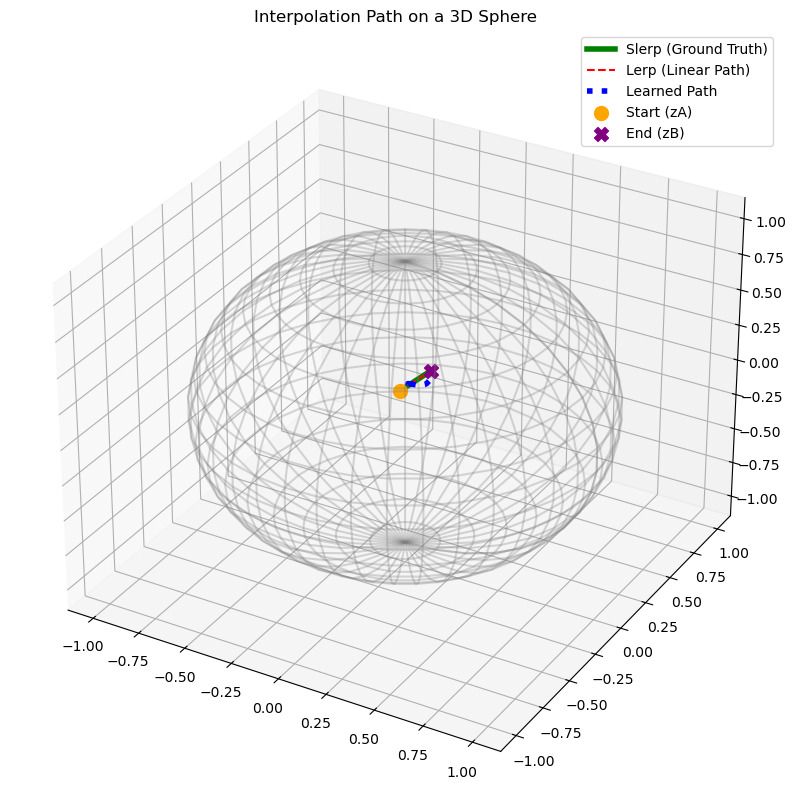

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. 하이퍼파라미터 설정 (Hyperparameters) ---
INPUT_DIM = 7
OUTPUT_DIM = 3
HIDDEN_DIM = 128
LEARNING_RATE = 1e-4
BATCH_SIZE = 256
NUM_EPOCHS = 50
LAMBDA = 0.1

# --- 2. 보간 네트워크 정의 (Interpolation Network Definition) ---
class InterpolationNet(nn.Module):
    def __init__(self):
        super(InterpolationNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, OUTPUT_DIM)
        )

    def forward(self, x):
        return self.network(x)

# --- 3. 구 표면 데이터셋 정의 (Sphere Dataset Definition) ---
class SphereDataset(Dataset):
    def __init__(self, num_samples=100000):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        z_a = torch.randn(3)
        z_b = torch.randn(3)
        z_a = z_a / torch.linalg.norm(z_a)
        z_b = z_b / torch.linalg.norm(z_b)
        alpha = torch.rand(1)
        return z_a, z_b, alpha

# --- 4. 손실 함수 정의 (Loss Function Definition) ---
def composite_loss(z_interp, z_linear, lambda_val):
    z_proj = z_interp / (torch.linalg.norm(z_interp, dim=1, keepdim=True) + 1e-8)
    loss_reproj = torch.mean(torch.sum((z_interp - z_proj)**2, dim=1))
    loss_attraction = torch.mean(torch.sum((z_interp - z_linear)**2, dim=1))
    total_loss = loss_reproj + lambda_val * loss_attraction
    return total_loss, loss_reproj, loss_attraction

# --- 5. 시각화 함수 정의 (Visualization Function Definition) ---
def visualize_results(model, device): # <--- device 인자 추가
    print("\nVisualizing trained model performance...")
    model.eval()
    
    # 테스트용 데이터 생성 및 GPU로 이동
    z_a = torch.randn(3)
    z_a = z_a / torch.linalg.norm(z_a)
    z_b = torch.randn(3)
    z_b = z_b / torch.linalg.norm(z_b)
    z_a, z_b = z_a.to(device), z_b.to(device) # <---

    alphas = torch.linspace(0, 1, 100).view(-1, 1).to(device) # <---
    
    # Slerp 계산 (CPU에서 계산 후 시각화)
    omega = torch.acos(torch.dot(z_a.cpu(), z_b.cpu()).clamp(-1, 1)) # <--- .cpu()
    sin_omega = torch.sin(omega)
    slerp_path = (torch.sin((1 - alphas.cpu()) * omega) / sin_omega) * z_a.cpu().unsqueeze(0) + \
                 (torch.sin(alphas.cpu() * omega) / sin_omega) * z_b.cpu().unsqueeze(0)

    # Lerp 계산 (CPU에서 계산 후 시각화)
    lerp_path = (1 - alphas.cpu()) * z_a.cpu().unsqueeze(0) + alphas.cpu() * z_b.cpu().unsqueeze(0) # <--- .cpu()
    
    # 네트워크가 학습한 경로 계산
    learned_path = []
    with torch.no_grad():
        for alpha in alphas:
            net_input = torch.cat([z_a, z_b, alpha], dim=0).unsqueeze(0)
            output = model(net_input)
            learned_path.append(output.squeeze(0))
    learned_path = torch.stack(learned_path)
    
    # 시각화를 위해 최종 결과를 CPU로 이동
    learned_path = learned_path.cpu() # <---
    z_a, z_b = z_a.cpu(), z_b.cpu() # <---

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x, y, z = np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v)
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.3)
    ax.plot(slerp_path[:, 0], slerp_path[:, 1], slerp_path[:, 2], label='Slerp (Ground Truth)', color='g', linewidth=4)
    ax.plot(lerp_path[:, 0], lerp_path[:, 1], lerp_path[:, 2], label='Lerp (Linear Path)', color='r', linestyle='--')
    ax.plot(learned_path[:, 0], learned_path[:, 1], learned_path[:, 2], label='Learned Path', color='b', linewidth=4, linestyle=':')
    ax.scatter(z_a[0], z_a[1], z_a[2], s=100, c='orange', marker='o', label='Start (zA)')
    ax.scatter(z_b[0], z_b[1], z_b[2], s=100, c='purple', marker='X', label='End (zB)')
    ax.set_title("Interpolation Path on a 3D Sphere")
    ax.legend()
    plt.show()

# --- 6. 메인 학습 로직 (Main Training Logic) ---
if __name__ == "__main__":
    # 장치 설정
    # DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # <---
    print(f"Using device: {device}") # <---

    # 모델, 데이터셋, 데이터로더 초기화
    model = InterpolationNet().to(device) # <---
    dataset = SphereDataset()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"Starting training for {NUM_EPOCHS} epochs...")
    for epoch in range(NUM_EPOCHS):
        total_loss_epoch = 0
        for z_a_batch, z_b_batch, alpha_batch in dataloader:
            # 배치 데이터를 GPU로 이동
            z_a_batch = z_a_batch.to(device) # <---
            z_b_batch = z_b_batch.to(device) # <---
            alpha_batch = alpha_batch.to(device) # <---
            
            # 네트워크 입력 준비
            net_input = torch.cat([z_a_batch, z_b_batch, alpha_batch], dim=1)

            # 순전파
            z_interp = model(net_input)
            
            # 손실 계산을 위한 선형 보간값(기준점) 계산
            z_linear = (1 - alpha_batch) * z_a_batch + alpha_batch * z_b_batch

            # 손실 계산 및 역전파
            optimizer.zero_grad()
            loss, _, _ = composite_loss(z_interp, z_linear, LAMBDA)
            loss.backward()
            optimizer.step()
            
            total_loss_epoch += loss.item()
        
        avg_loss = total_loss_epoch / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Average Loss: {avg_loss:.6f}")

    print("Training finished.")
    
    # 학습 완료 후 결과 시각화
    visualize_results(model, device) # <--- device 인자 전달